## 1️⃣ Import Library & Setup

In [3]:

import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


## 2️⃣ Data Preprocessing & Augmentasi

In [4]:

data_dir = 'C:\\Users\\kinan\\Documents\\UAS-DATASET\\FishImgDataset'

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)
print(f'Classes: {class_names}')


Classes: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']


## 3️⃣ Modeling

In [5]:

model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\kinan/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:21<00:00, 2.20MB/s]


## 4️⃣ Training & Validasi

In [6]:

num_epochs = 10
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc  = running_corrects.double() / len(train_dataset)
    
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    model.eval()
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            val_corrects += torch.sum(preds == labels.data)
    
    val_acc = val_corrects.double() / len(val_dataset)
    print(f'Val Acc: {val_acc:.4f}')
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
    
    scheduler.step()


Epoch 1/10
Train Loss: 1.4672 Acc: 0.5825
Val Acc: 0.6514
Epoch 2/10
Train Loss: 0.8635 Acc: 0.7474
Val Acc: 0.7684
Epoch 3/10
Train Loss: 0.6882 Acc: 0.7980
Val Acc: 0.8081
Epoch 4/10
Train Loss: 0.5755 Acc: 0.8293
Val Acc: 0.8262
Epoch 5/10
Train Loss: 0.4636 Acc: 0.8552
Val Acc: 0.8880
Epoch 6/10
Train Loss: 0.3790 Acc: 0.8823
Val Acc: 0.8666
Epoch 7/10
Train Loss: 0.4107 Acc: 0.8799
Val Acc: 0.8382
Epoch 8/10
Train Loss: 0.1797 Acc: 0.9482
Val Acc: 0.9760
Epoch 9/10
Train Loss: 0.1104 Acc: 0.9699
Val Acc: 0.9800
Epoch 10/10
Train Loss: 0.0839 Acc: 0.9784
Val Acc: 0.9862


## 5️⃣ Evaluasi Model


Classification Report:
                       precision    recall  f1-score   support

               Bangus       0.89      1.00      0.94        34
        Big Head Carp       0.98      0.98      0.98        43
   Black Spotted Barb       1.00      1.00      1.00        40
              Catfish       0.97      0.97      0.97        62
       Climbing Perch       0.90      0.93      0.92        30
 Fourfinger Threadfin       0.97      1.00      0.99        38
       Freshwater Eel       0.93      1.00      0.96        55
       Glass Perchlet       0.99      0.97      0.98        77
                 Goby       0.99      0.98      0.99       124
            Gold Fish       0.95      1.00      0.98        41
              Gourami       1.00      0.98      0.99        63
           Grass Carp       0.98      1.00      0.99       238
 Green Spotted Puffer       1.00      1.00      1.00        22
          Indian Carp       1.00      1.00      1.00        53
  Indo-Pacific Tarpon       0.

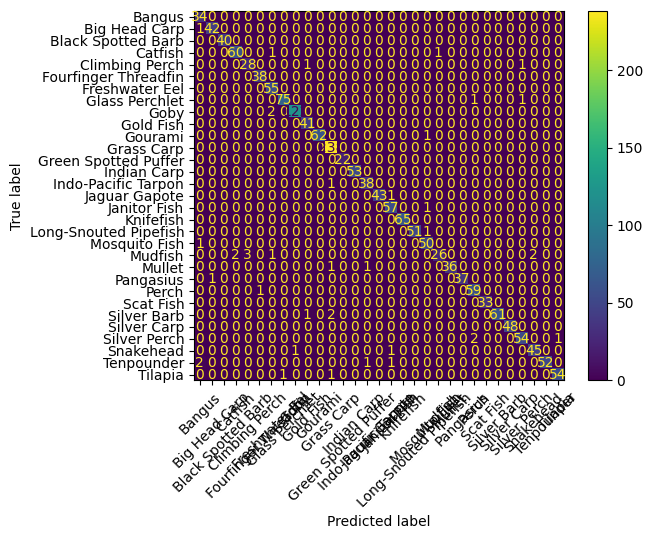

AUC-ROC: 0.9997


In [7]:

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)
plt.show()

all_labels_onehot = np.eye(num_classes)[all_labels]
roc_auc = roc_auc_score(all_labels_onehot, all_probs, multi_class='ovr')
print(f'AUC-ROC: {roc_auc:.4f}')


Framework: PyTorch

Model:
🔹 Transfer Learning pakai ResNet18 pretrained di ImageNet
🔹 Final layer diubah ke jumlah class ikan

Preprocessing:
🔹 Resize → 224x224
🔹 Augmentasi di training: random flip, rotation, color jitter
🔹 Normalisasi pakai mean & std ImageNet

Training:
🔹 Optimizer: Adam (lr=0.001)
🔹 Loss: CrossEntropyLoss
🔹 Scheduler: StepLR

Evaluasi:
🔹 Classification report (precision, recall, F1-score)
🔹 Confusion Matrix
🔹 AUC-ROC (macro)

Terdapat kelas imbalance dimana ada beberapa kelas yang memiliki jumlah di bawah 50. Namun hasil akurasi masih bagus tanpa menunjukkan overfitting atau underfitting